In [76]:
import numpy as np
import pandas as pd
import pdb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import multiprocessing
import pdb

In [2]:
def data_prepare(data):
    data_copy = data.copy()
    numeric_col = list()
    category_col = list()
    for _col in data_copy.columns:
        try:
            data_copy.loc[:, _col] = data_copy.loc[:, _col].astype(np.float32)
            numeric_col.append(_col)
        except ValueError:
            label_encoder = LabelEncoder().fit(data_copy.loc[:, _col].values)
            _class = label_encoder.classes_
            tmp_col = label_encoder.transform(data_copy.loc[:, _col].values)
            if 'unknown' in _class:
                tmp_col = np.where(tmp_col==label_encoder.transform(['unknown']), np.nan, tmp_col)
            elif 'yes' in _class:
                tmp_col = np.where(tmp_col==label_encoder.transform(['yes']), 1, tmp_col)
            elif 'no' in _class:
                tmp_col = np.where(tmp_col==label_encoder.transform(['no']), 0, tmp_col)

            data_copy.loc[:, _col] = tmp_col.astype(np.float32)
            category_col.append(_col)

    return data_copy, numeric_col, category_col

In [3]:
data = pd.read_csv('D:/GT/ML/a1/bank-additional/bank-additional-full.csv', sep=';', header=0)
# test_data = pd.read_csv('D:/GT/ML/a1/bank-additional/bank-additional.csv', sep=';', header=0)
data_copy, numeric_col, category_col = data_prepare(data)
data_copy.mask(data_copy.isnull(), data_copy.median(0), axis=1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(data_copy.iloc[:, :-1], data_copy['y'], test_size=0.05, random_state=3407)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### DT

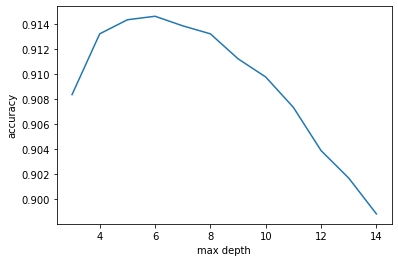

In [57]:
def md_score(d):
    dt = DecisionTreeClassifier(max_depth=d)
    return cross_val_score(dt, x_train, y_train, scoring='accuracy', cv=5).mean()

depths = np.arange(3, 15)
vals = np.linspace(0, 0.2, 100)
scores = [md_score(d) for d in depths]
plt.plot(depths, scores)
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

In [60]:
dt = DecisionTreeClassifier(criterion='gini',max_depth=6)
dt.fit(x_train, y_train)
print(dt.score(x_train, y_train))
print(cross_val_score(dt, x_train, y_train, scoring='accuracy', cv=5).mean())
print(dt.score(x_test, y_test))

0.9208239623798814
0.914690456151028
0.9189320388349514


In [29]:
depths = np.arange(3, 10)
vals = np.linspace(0, 0.05, 5)
min_leaf = [1,5,10,20]
min_split = [10,20,40,60,100]
param_grid = [{'min_impurity_decrease': vals, 'max_depth': depths, 'criterion': ['gini', 'entropy'], 
               'min_samples_leaf':min_leaf, 'min_samples_split':min_split}]
gs = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, scoring='accuracy', cv=5, return_train_score=True)
gscv = gs.fit(x_train, y_train)
print('gscv')
cv_result = pd.DataFrame.from_dict(gscv.cv_results_)
with open('cv_result.csv', 'w') as f:
    cv_result.to_csv(f)
print(gscv.best_estimator_)

gscv
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [61]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=6, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=10)
dt.fit(x_train, y_train)
print(dt.score(x_train, y_train))
print(cross_val_score(dt, x_train, y_train, scoring='accuracy', cv=5).mean())
print(dt.score(x_test, y_test))

0.9207728480883255
0.9147160217866344
0.9189320388349514


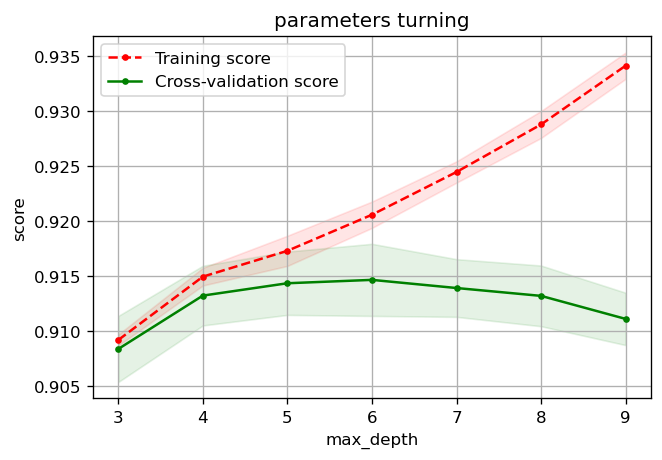

In [27]:
param_grid = [{'max_depth': depths}]
gs = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, scoring='accuracy', cv=5, return_train_score=True)
gscv = gs.fit(x_train, y_train)
train_scores_mean = gscv.cv_results_['mean_train_score']
train_scores_std = gscv.cv_results_['std_train_score']
test_scores_mean = gscv.cv_results_['mean_test_score']
test_scores_std = gscv.cv_results_['std_test_score']
plt.figure(figsize=(6, 4), dpi=120)   # 指定了大小和分辨率，还有背景颜色facecolor，还可以有边框之类的
plt.title('parameters turning')
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('score')
plt.fill_between(depths, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(depths, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(depths, train_scores_mean, '.--', color="r", label="Training score")
plt.plot(depths, test_scores_mean, '.-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

### GBDT

In [18]:
dt = GradientBoostingClassifier()
dt.fit(x_train, y_train)
print(cross_val_score(dt, x_train, y_train, scoring='accuracy', cv=5).mean())
print(dt.score(x_test, y_test))

0.9168627907084085
0.9121359223300971


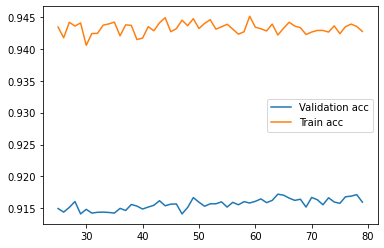

In [63]:
accuracy = []
train_acc = []
max_estimators = 80
for i in range(25, max_estimators):
    score = cross_val_score(GradientBoostingClassifier(
        n_estimators=i, learning_rate=10.0/float(i), 
        max_depth=6, min_samples_leaf=1, min_samples_split=10), 
                            x_train, y_train, cv=5, scoring='accuracy').mean()
    model = GradientBoostingClassifier(
        n_estimators=i, learning_rate=10.0/float(i), 
        max_depth=6, min_samples_leaf=1, min_samples_split=10)
    model.fit(x_train, y_train)
    accuracy.append(score)
    train_acc.append(model.score(x_train, y_train))
plt.plot(range(25, max_estimators), accuracy, label='Validation acc')
plt.plot(range(25, max_estimators), train_acc, label='Train acc')
plt.show()

In [70]:
pd.Series(accuracy).sort_values()

22    0.914128
4     0.914128
10    0.914256
6     0.914256
9     0.914358
7     0.914384
1     0.914409
8     0.914409
12    0.914665
5     0.914844
15    0.914895
0     0.914972
11    0.914997
2     0.915150
23    0.915150
44    0.915202
30    0.915202
16    0.915202
26    0.915329
14    0.915355
19    0.915406
17    0.915483
47    0.915559
32    0.915559
13    0.915610
20    0.915661
21    0.915687
28    0.915713
27    0.915713
50    0.915789
34    0.915840
37    0.915892
31    0.915943
25    0.915968
54    0.915968
49    0.915994
29    0.916019
33    0.916045
3     0.916070
35    0.916096
18    0.916198
38    0.916249
42    0.916249
46    0.916352
43    0.916428
36    0.916480
41    0.916607
48    0.916658
24    0.916684
45    0.916709
51    0.916812
52    0.916914
40    0.917067
53    0.917144
39    0.917220
dtype: float64

In [72]:
vals = np.linspace(0, 0.05, 5)
min_leaf = [1,5,10,20]
min_split = [10,20,40,60,100]
param_grid = [{'min_impurity_decrease': vals, 
               'min_samples_leaf':min_leaf, 'min_samples_split':min_split}]
gs = GridSearchCV(estimator=GradientBoostingClassifier(max_depth=6, n_estimators=64, learning_rate=10/64), 
                  param_grid=param_grid, scoring='accuracy', cv=5, return_train_score=True)
gscv = gs.fit(x_train, y_train)
print('gscv')
cv_result = pd.DataFrame.from_dict(gscv.cv_results_)
with open('cv_result.csv', 'w') as f:
    cv_result.to_csv(f)
print(gscv.best_estimator_)

gscv
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15625, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.037500000000000006,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=20, min_weight_fraction_leaf=0.0,
              n_estimators=64, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)


In [73]:
gbdt = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=10/64, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0375,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=20, min_weight_fraction_leaf=0.0,
              n_estimators=64, presort='auto', random_state=3407,
              subsample=1.0, verbose=0, warm_start=False)
gbdt.fit(x_train, y_train)
print(gbdt.score(x_train, y_train))
print(cross_val_score(gbdt, x_train, y_train, scoring='accuracy', cv=5).mean())
print(gbdt.score(x_test, y_test))

0.9422152933960335
0.9178849720498861
0.9218446601941748


### SVM

In [74]:
svc = SVC(kernel='linear')
print(cross_val_score(svc, x_train, y_train, scoring='accuracy', cv=5).mean())
svc.fit(x_train, y_train)
sep = np.array(svc.support_vectors_).reshape(-1, 2)

0.9003525882954279


In [75]:
# 调参主要使用C系数（松弛变量），核函数的选择， 还有degree是poly的次数，gamma是核函数的系数
param_grid = [{'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'C': [0.5, 1.0, 3.0, 5.0, 8.0, 12.0, 15.0, 20.0]}]
gs = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring='accuracy', cv=5,
                    n_jobs=multiprocessing.cpu_count())
gs.fit(x_train, y_train)
print(gs.best_estimator_)
print(gs.best_score_)

SVC(C=20.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9048507462686567


In [77]:
# 调参主要使用C系数（松弛变量），核函数的选择， 还有degree是poly的次数，gamma是核函数的系数
param_grid = [{'C': [15.0, 20.0, 25.0, 30.0], 'gamma': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]}]
gs = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, scoring='accuracy', cv=5,
                    n_jobs=multiprocessing.cpu_count())
gs.fit(x_train, y_train)
print(gs.best_estimator_)
print(gs.best_score_)

SVC(C=25.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9082754038029033


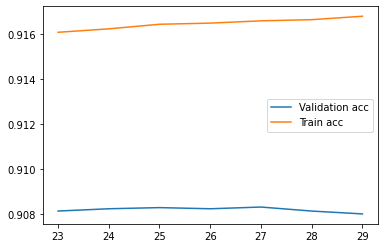

In [89]:
accuracy = []
train_acc = []
for i in range(23, 30):
    score = cross_val_score(SVC(C=i, kernel='rbf', gamma=0.2), x_train, y_train, cv=5, scoring='accuracy').mean()
    model = SVC(C=i, kernel='rbf', gamma=0.2)
    model.fit(x_train, y_train)
    accuracy.append(score)
    train_acc.append(model.score(x_train, y_train))
plt.plot(range(23, 30), accuracy, label='Validation acc')
plt.plot(range(23, 30), train_acc, label='Train acc')
plt.legend()
plt.show()

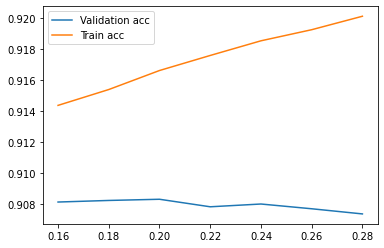

In [94]:
accuracy = []
train_acc = []
x = [0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28]
for i in x:
    score = cross_val_score(SVC(C=27, kernel='rbf', gamma=i), x_train, y_train, cv=5, scoring='accuracy').mean()
    model = SVC(C=27, kernel='rbf', gamma=i)
    model.fit(x_train, y_train)
    accuracy.append(score)
    train_acc.append(model.score(x_train, y_train))
plt.plot(x, accuracy, label='Validation acc')
plt.plot(x, train_acc, label='Train acc')
plt.legend()
plt.show()

In [96]:
svc = SVC(kernel='rbf', C=27, gamma=0.2)
print(cross_val_score(svc, x_train, y_train, scoring='accuracy', cv=5).mean())
svc.fit(x_train, y_train)
sep = np.array(svc.support_vectors_).reshape(-1, 2)
# print(sep)
print(svc.score(x_test, y_test))

0.9083009802404979
0.9092233009708738


In [97]:
print(svc.score(x_train, y_train))

0.916607033326518


### KNN

In [90]:
param_grid = [{'weights': ['uniform','distance'], 'n_neighbors': [15, 20, 25, 30, 35, 40]}]
gs = GridSearchCV(estimator=KNeighborsClassifier(algorithm='auto'), 
                  param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=multiprocessing.cpu_count())
gs.fit(x_train, y_train)
print(gs.best_estimator_)
print(gs.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')
0.9000971171539562


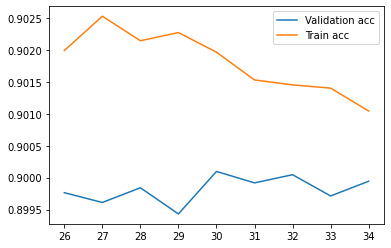

In [93]:
accuracy = []
train_acc = []
for i in range(26, 35):
    score = cross_val_score(KNeighborsClassifier(n_neighbors=i, algorithm='auto', weights='uniform'), 
                            x_train, y_train, cv=5, scoring='accuracy').mean()
    model = KNeighborsClassifier(n_neighbors=i, algorithm='auto', weights='uniform')
    model.fit(x_train, y_train)
    accuracy.append(score)
    train_acc.append(model.score(x_train, y_train))
plt.plot(range(26, 35), accuracy, label='Validation acc')
plt.plot(range(26, 35), train_acc, label='Train acc')
plt.legend()
plt.show()

In [100]:
knn = KNeighborsClassifier(n_neighbors=27, weights='uniform', algorithm='auto')
knn.fit(x_train, y_train)
print(knn.score(x_train, y_train))
print(cross_val_score(knn, x_train, y_train, scoring='accuracy', cv=5).mean())
print(knn.score(x_test, y_test))

0.9025250460028624
0.8996117138645975
0.9014563106796116


### ANN

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [202]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 32)
        #self.fc3 = nn.Linear(32, 20)
        self.fc4 = nn.Linear(32, 2)
        self.bn1 = nn.BatchNorm1d(64, track_running_stats=True)
        self.bn2 = nn.BatchNorm1d(32, track_running_stats=True)
        self.dropout = nn.Dropout(0.125)
        self.relu = nn.ReLU()
        
        self.apply(self._init_weights)
    
    def forward(self, x):
        x_copy = x.clone()
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #x = self.relu(self.fc3(x))
        #x = self.relu(self.bn1(self.fc1(x)))
        #x = self.dropout(x)
        #x = self.relu(self.bn2(self.fc2(x)))
        #x = self.dropout(x)
        x = self.fc4(x)
        return x#.squeeze()
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1)

In [103]:
batch_size = 64
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train.values))
train_length = int(len(train_dataset) * 0.9)
train_dataset, dev_dataset = random_split(train_dataset, [train_length, len(train_dataset)-train_length])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test.values))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [203]:
batch_num = np.ceil(train_length / batch_size)
epoch = 80
max_lr = 0.3

#torch.cuda.empty_cache()
torch.manual_seed(3407)
model = MLP()

In [204]:
batch_loss = list()
batch_acc = list()
eval_loss = list()
eval_acc = list()
pred_list = list()
target_list = list()
tmp_eval_loss = 0
tmp_max_loss = -np.inf
patience_charge = 0

In [205]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=max_lr, weight_decay=1e-03, amsgrad=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10*batch_num, gamma=0.8, last_epoch=-1)
loss_fn = nn.CrossEntropyLoss()

Epoch: 0, batch: 0, loss: 1.006
Epoch: 0, batch: 100, loss: 0.4264
Epoch: 0, batch: 200, loss: 0.474
Epoch: 0, batch: 300, loss: 0.3471
Epoch: 0, batch: 400, loss: 0.4069
Epoch: 0, batch: 500, loss: 0.3784
Epoch: 0, train ave.acc: 0.842
dev set:
Epoch: 0, dev ave.loss: 0.3365, ave.acc: 0.895

Epoch: 1, batch: 0, loss: 0.3132
Epoch: 1, batch: 100, loss: 0.2792
Epoch: 1, batch: 200, loss: 0.347
Epoch: 1, batch: 300, loss: 0.6645
Epoch: 1, batch: 400, loss: 0.3908
Epoch: 1, batch: 500, loss: 0.4121
Epoch: 1, train ave.acc: 0.886
dev set:
Epoch: 1, dev ave.loss: 0.3333, ave.acc: 0.895

Epoch: 2, batch: 0, loss: 0.4079
Epoch: 2, batch: 100, loss: 0.4281
Epoch: 2, batch: 200, loss: 0.3121
Epoch: 2, batch: 300, loss: 0.3768
Epoch: 2, batch: 400, loss: 0.4224
Epoch: 2, batch: 500, loss: 0.2994
Epoch: 2, train ave.acc: 0.886
dev set:
Epoch: 2, dev ave.loss: 0.3368, ave.acc: 0.895

Epoch: 3, batch: 0, loss: 0.3773
Epoch: 3, batch: 100, loss: 0.4083
Epoch: 3, batch: 200, loss: 0.3457
Epoch: 3, ba

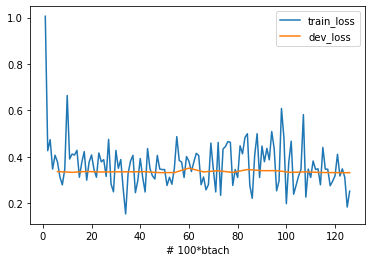

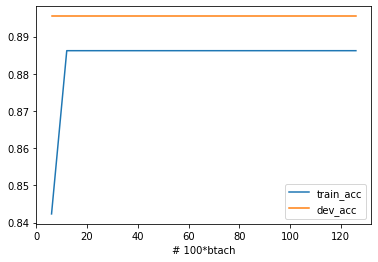

In [206]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model = model.to(device, non_blocking=True)

for epoch_id in range(epoch):
    model.train()
    pred_list = list()
    target_list = list()
    for batch_id, (_input, _target) in enumerate(train_loader):
        if torch.cuda.is_available():
            device = next(model.parameters()).device
            _input = _input.to(device, non_blocking=True)
            _target = _target.to(device, non_blocking=True).long()
        _output = model(_input)
        #_output = torch.max(F.softmax(_output,dim=0),1)[1]
        loss = loss_fn(_output, _target)
        
        _output = torch.max(F.softmax(_output,dim=0),1)[1]
        pred_list.extend(_output.numpy())
        target_list.extend(_target.numpy())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if batch_id % 100 == 0:
            print('Epoch: {}, batch: {}, loss: {:.4}'.format(epoch_id, batch_id, loss.item()))
            batch_loss.append(loss.item())
        
        del _input, _target, loss
        
    batch_acc.append(np.sum(np.array(pred_list)==np.array(target_list)) / len(target_list))
    print('Epoch: {}, train ave.acc: {:.3}'.format(epoch_id, batch_acc[-1]))
        
    print('dev set:')
    model.eval()
    tmp_eval_loss = 0.0
    pred_list = list()
    target_list = list()
    for batch_id, (_input, _target) in enumerate(dev_loader):
        if torch.cuda.is_available():
            device = next(model.parameters()).device
            _input = _input.to(device, non_blocking=True)
            _target = _target.to(device, non_blocking=True).long()
        with torch.no_grad():
            _output = model(_input)
            loss = loss_fn(_output, _target)
            tmp_eval_loss += loss.item()
            
            _output = torch.max(F.softmax(_output,dim=0),1)[1]
            pred_list.extend(_output.numpy())
            target_list.extend(_target.numpy())

    eval_loss.append(tmp_eval_loss / (batch_id+1))
    eval_acc.append(np.sum(np.array(pred_list)==np.array(target_list)) / len(target_list))
    print('Epoch: {}, dev ave.loss: {:.4}, ave.acc: {:.3}'.format(epoch_id, eval_loss[-1], eval_acc[-1]))
    print()
    if eval_acc[-1] > tmp_max_loss:
        tmp_max_loss = eval_acc[-1]
        patience_charge = 0
        torch.save(model, './tmp_model.pkl')
    else:
        patience_charge += 1
    
    if patience_charge == 20:
        print('Early stop at epoch {}'.format(epoch_id))
        break

model = model.to('cpu')
model = torch.load('./tmp_model.pkl')

print('test set:')
model.eval()
tmp_eval_loss = 0.0
for batch_id, (_input, _target) in enumerate(test_loader):
    if torch.cuda.is_available():
        device = next(model.parameters()).device
        _input = _input.to(device, non_blocking=True)
        _target = _target.to(device, non_blocking=True).long()
    with torch.no_grad():
        _output = model(_input)
        loss = loss_fn(_output, _target)
    tmp_eval_loss += loss.item()
print('Epoch: {}, test ave.loss: {:.4}'.format(epoch_id, tmp_eval_loss / (batch_id+1)))

plt.figure()
plt.plot(list(range(1, len(batch_loss)+1)), batch_loss, label='train_loss')
plt.plot(np.arange(1, len(eval_loss)+1)*6, eval_loss, label='dev_loss')
plt.legend()
plt.xlabel('# 100*btach')
plt.show()

plt.figure()
plt.plot(np.arange(1, len(batch_acc)+1)*6, batch_acc, label='train_acc')
plt.plot(np.arange(1, len(eval_acc)+1)*6, eval_acc, label='dev_acc')
plt.legend()
plt.xlabel('# 100*btach')
plt.show()

In [207]:
model.eval()
pred_list = list()
target_list = list()
for batch_id, (_input, _target) in enumerate(train_loader):
    if torch.cuda.is_available():
        device = next(model.parameters()).device
        _input = _input.to(device, non_blocking=True)
        _target = _target.to(device, non_blocking=True).long()
    with torch.no_grad():
        _output = model(_input)
        _output = torch.max(F.softmax(_output,dim=0),1)[1]
        pred_list.extend(_output.numpy())
        target_list.extend(_target.numpy())

acc = np.sum(np.array(pred_list)==np.array(target_list)) / len(target_list)
print('train ave.acc: {:.4}'.format(acc))

pred_list = list()
target_list = list()
for batch_id, (_input, _target) in enumerate(dev_loader):
    if torch.cuda.is_available():
        device = next(model.parameters()).device
        _input = _input.to(device, non_blocking=True)
        _target = _target.to(device, non_blocking=True).long()
    with torch.no_grad():
        _output = model(_input)
        _output = torch.max(F.softmax(_output,dim=0),1)[1]
        pred_list.extend(_output.numpy())
        target_list.extend(_target.numpy())

acc = np.sum(np.array(pred_list)==np.array(target_list)) / len(target_list)
print('dev ave.acc: {:.4}'.format(acc))

pred_list = list()
target_list = list()
for batch_id, (_input, _target) in enumerate(test_loader):
    if torch.cuda.is_available():
        device = next(model.parameters()).device
        _input = _input.to(device, non_blocking=True)
        _target = _target.to(device, non_blocking=True).long()
    with torch.no_grad():
        _output = model(_input)
        _output = torch.max(F.softmax(_output,dim=0),1)[1]
        pred_list.extend(_output.numpy())
        target_list.extend(_target.numpy())

acc = np.sum(np.array(pred_list)==np.array(target_list)) / len(target_list)
print('test ave.acc: {:.4}'.format(acc))

train ave.acc: 0.8862
dev ave.acc: 0.8955
test ave.acc: 0.8913
